# Analyzing
This notebook shows how to fit the autocorrelation curves from a measurement to get the corresponding parameters of scatterer
dynamics (i.e., `db` and/or `v_ms`).

## Data generation
Let's start by generating a measurement. We'll simulate an occlusion, using a Brownian model for scatterer motion and a homogeneous semi-infinite
model for the geometry. First of all, let's generate the time course for `db`.

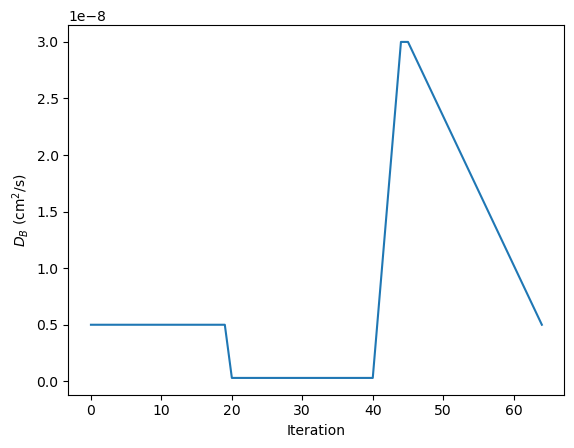

In [39]:
import numpy as np
import matplotlib.pyplot as plt

baseline_value = 5e-9
baseline_length = 20
occlusion_value = 3e-10
occlusion_length = 20
peak_value = 6 * baseline_value
rising_time = 5
falling_time = 20
total_length = baseline_length + occlusion_length + rising_time + falling_time
db = np.zeros(total_length)
db[:baseline_length] = baseline_value
db[baseline_length:baseline_length + occlusion_length] = occlusion_value
db[baseline_length + occlusion_length:baseline_length + occlusion_length + rising_time] = np.linspace(occlusion_value, peak_value, rising_time)
db[baseline_length + occlusion_length + rising_time:baseline_length + occlusion_length + rising_time + falling_time] = np.linspace(peak_value, baseline_value, falling_time)

plt.plot(db)
plt.xlabel("Iteration")
plt.ylabel(r"$D_B$ (cm$^2$/s)")
plt.show()

Now that we have `db`, we can create our autocorrelation curves the way we saw in `1-forward modeling.ipynb`. For simplicity's sake, we will
keep all other parameters (absorption, scattering, countrate...) constant during the measurement.

We end up with a 2D `g2_norm` matrix, whose rows are the autocorrelation time bins and columns are the iterations.

In [40]:
from forward import common
import forward.homogeneous_semi_inf as hsi

tau = np.load("data/tau.npz")["tau_hardware"]
lambda0 = 785
mua = 0.1
musp = 10
rho = 2
n = 1.4
beta = 0.5
g1_norm = np.zeros((len(tau), len(db)))

for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)

g2_norm = 1 + beta * g1_norm**2

With the autocorrelation curves in hand, we can now add some noise to mimic a real measurement, as seen in `1-forward_modeling.ipynb`.

Note that here we are adapting `tau_lim` to the value of `db`, see the documentation of `NoiseAdder` for more info.

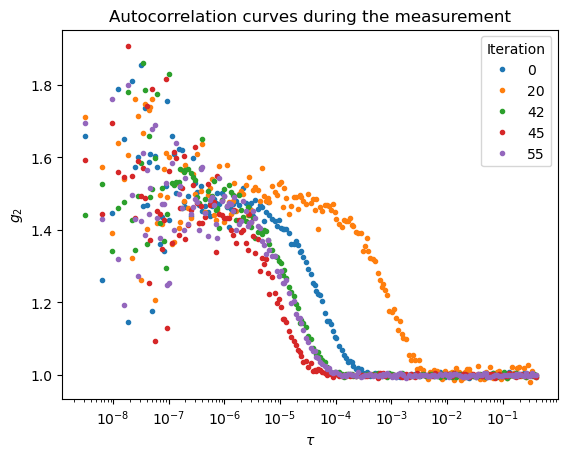

In [41]:
from utils import noise

k0 = 2 * np.pi / (lambda0 * 1e-7)
tau_lim = mua / (10 * musp * k0**2 * db)
noise_adder = noise.NoiseAdder(
    g2_norm=g2_norm,
    tau=tau,
    t_integration=1,
    countrate=60e3,
    beta=0.5,
    n_speckle=4,
    tau_lim=tau_lim,
    ensure_decreasing=True
)

g2_norm_noisy = noise_adder.add_noise()
iterations_plot = [
    0,
    baseline_length,
    baseline_length + occlusion_length + rising_time // 2,
    baseline_length + occlusion_length + rising_time,
    baseline_length + occlusion_length + rising_time + falling_time // 2
]
for i in iterations_plot:
    plt.semilogx(tau, g2_norm_noisy[:, i], linestyle='none', marker='.', label=i)
plt.legend(title="Iteration")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$g_2$")
plt.title("Autocorrelation curves during the measurement")
plt.show()

## Data analysis
### Fitting
Fitting is implemented through the `inverse.homogeneous_semi_inf` module, which provides the `FitHomogeneous` class. It is used by
providing the various parameters (e.g., `tau`, `g2_norm`, `mua`, `musp`, ...) to initialize an instance, and then calling
`FitHomogeneous.fit()` on the instance.

First of all, we need to choose a model for scatterer motion, which is done through the `inverse.fit_homogeneous.MSDModelFit` class:
we create an instance of `MSDModelFit` which we will then pass as an argument to the `FitHomogeneous` class constructor.
Creating an instance of `MSDModelFit` is as easy as specifying the model (Brownian, ballistic or hybrid), the initial value of the
parameter(s) and their bounds to use during the fitting procedure (use `None`, rather than `np.inf`, for no bounds).

In our case, let's use a Brownian model with initial value Db0 = 1e-8 cm^2/s and lower bound 0 (no upper bound):

In [42]:
import inverse.fit_homogeneous as fit_hom

msd_model = fit_hom.MSDModelFit(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})

Now, we need to choose a way to calculate `beta` during the fitting procedure. To do so, similarly to how we did for `msd_model`, we
create an instance of the `inverse.fit_homogeneous.BetaCalculator` class, which we will then pass to the `FitHomogeneous` class constructor.
To create an instance of `BetaCalculator` we simply pass to its constructor one of the available modes, along with any additional parameters,
which depend on the mode. The supported modes are the following:
* `fixed`: the simplest one, fixes `beta` for all curves to the value specified by the `beta_fixed` argument.
* `raw`: estimates `beta` from the raw `g2_norm` curve by averaging the curve over the interval specified by the
`tau_lims` argument and subtracting 1.
* `raw_weighted`: similar to `raw`, but weighs the average to compensate for the early decay of the curve.
Requires the additional argument `beta0`, which should be close to the actual value and is used to weigh the curve correctly.
* `fit`: fits `beta` together with the `msd` parameters. Requires the additional arguments `beta_init` (the initial value)
and, optionally, the bounds `beta_bounds`

Let's start simple and use the `fixed` mode, fixing `beta` to the ground truth value:

In [43]:
beta_calculator =  fit_hom.BetaCalculator(mode="fixed", beta_fixed=beta)

Finally, we must specify the geometric model by means of a fitting function. The `FitHomogeneous` class is flexible, allowing
to specify any `g1_norm` function as long as it takes as input a single `msd` (that is, the motion of the scatterer is the same
in the whole volume). Once we have chosen such function (typically from the `forward` model), we can simply pass it to the class
constructor. Note that we pass the function itself: the fitter will fit the parameters of the specified `msd_model`, while all
additional arguments (such as `mua`, `musp`, `rho`, etc.) must be passed as keyword arguments to the constructor.

In our case, we will use the homogeneous semi-infinite model that we also used for generating the curves, that is `hsi.g1_norm`:

In [44]:
fitting_function = hsi.g1_norm

The last two arguments we can pass to `FitHomogeneous` are `tau_lims_fit`, a 2-tuple with the extreme values of `tau` used
for fitting (that is, `g2_norm` is fitted between `tau_lims_fit[0]` and `tau_lims_fit[1]`), and `g2_lim_fit`, the lowest value
of `g2_norm` up to which the fit is done (that is, the points of `g2_norm` after it has crossed `g2_lim_fit` are not used in the
fitting). Both `tau_lims_fit` and `g2_lim_fit` are optional parameters: one can pass both, just one, or neither. If both are
passed, the fitting range will satisfy both of them.

In our case, we will specify both parameters:

In [45]:
tau_lims_fit = (1e-7, 1e-3)
g2_lim_fit = 1.13

We now have everything we need to fit our measurement. Let's create an instance of `FitHomogeneous` with all the options we selected.
Notice that the arguments of `fitting_function` besides `msd` must be passed last, as keyword arguments:

In [46]:
fitter = fit_hom.FitHomogeneous(
    tau,
    g2_norm_noisy,
    fitting_function,
    msd_model,
    beta_calculator,
    tau_lims_fit,
    g2_lim_fit,
    mua=mua,
    musp=musp,
    rho=rho,
    n=n,
    lambda0=lambda0
)

To perform the fit, we call `fitter.fit()`. We can specify a `plot_interval` to plot 1 every `plot_interval` curves to check
the fitting. If `plot_interval` is not passed, or if it is `0`, no plotting is done.

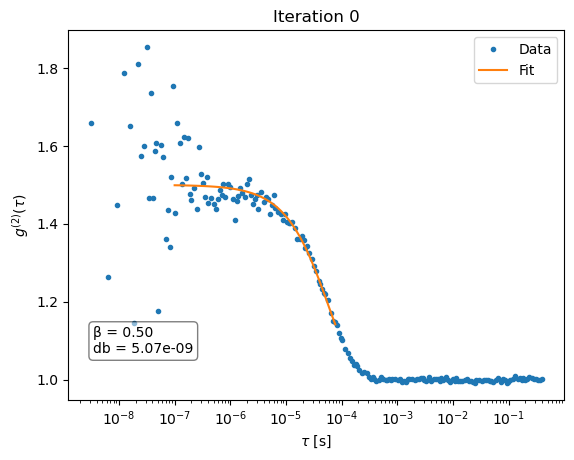

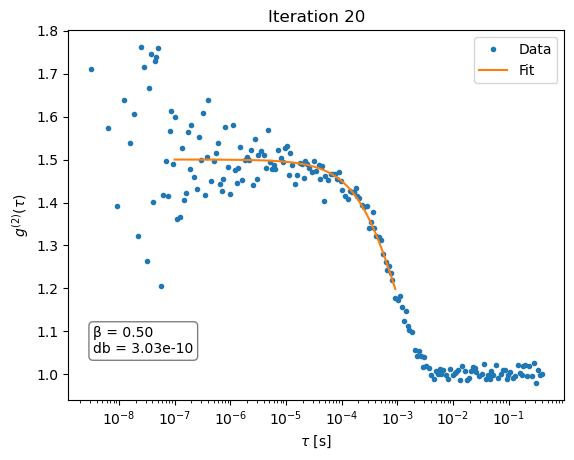

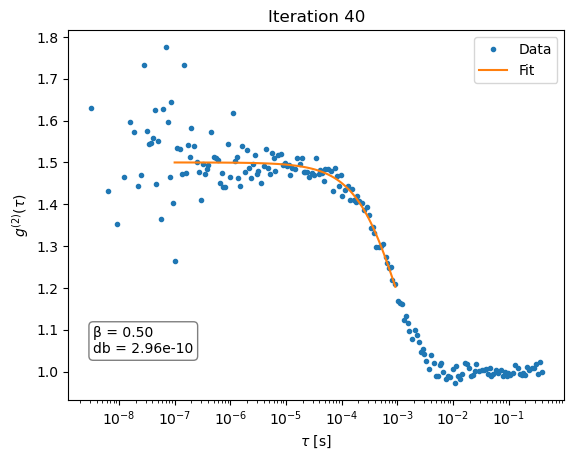

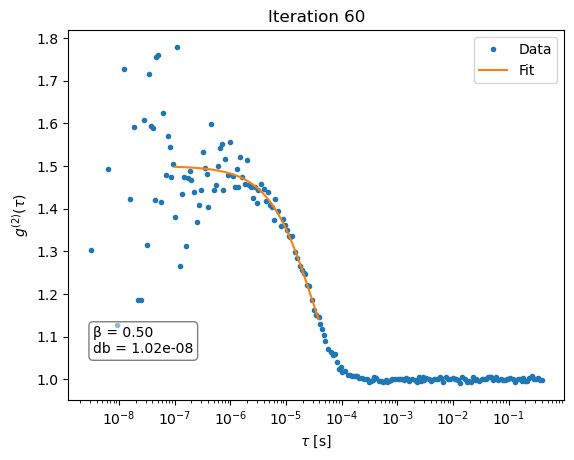

In [47]:
fitted_data = fitter.fit(plot_interval=20)

The `fit()` method returns a `pandas` `dataframe` whose columns are the `msd` parameters (`db` and/or `v_ms`), `beta`, `chi2`, and `r2`:

In [48]:
fitted_data

,db,beta,chi2,r2
0,5.067693e-09,0.5,0.117260,0.864371
1,5.004394e-09,0.5,0.181549,0.801039
2,4.925613e-09,0.5,0.128965,0.814178
3,5.045850e-09,0.5,0.181053,0.814075
4,4.919653e-09,0.5,0.145689,0.831151
...,...,...,...,...
60,1.016729e-08,0.5,0.268063,0.690850
61,9.127426e-09,0.5,0.222434,0.753518
62,7.660138e-09,0.5,0.169271,0.818382
63,6.335006e-09,0.5,0.161473,0.834887


We can plot the fitted `db` together with the ground truth value for comparison.

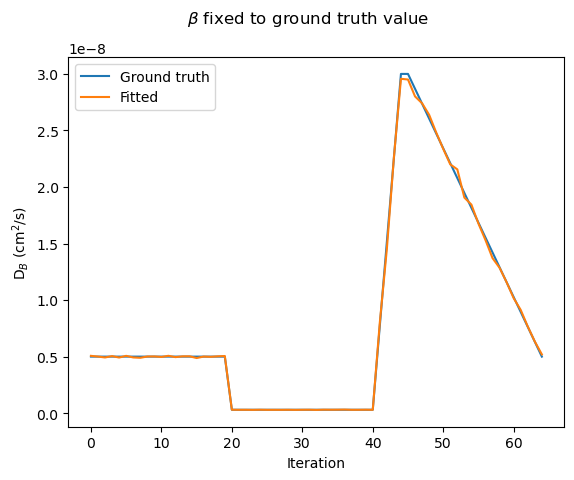

In [49]:
plt.plot(db, label="Ground truth")
plt.plot(fitted_data["db"], label="Fitted")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"D$_B$ (cm$^2$/s)")
plt.suptitle(r"$\beta$ fixed to ground truth value")
plt.show()

Since we fixed `beta` to its ground-truth value and the noise is relatively low, the results are excellent. Let's retry using the `raw`
mode of `BetaCalculator`.

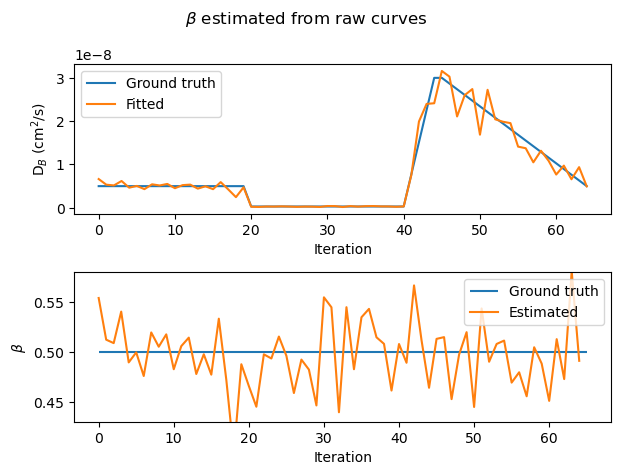

In [50]:
beta_calculator = fit_hom.BetaCalculator(mode="raw", tau_lims=(1e-7, 2e-7))
fitter = fit_hom.FitHomogeneous(
    tau,
    g2_norm_noisy,
    fitting_function,
    msd_model,
    beta_calculator,
    tau_lims_fit,
    g2_lim_fit,
    mua=mua,
    musp=musp,
    rho=rho,
    n=n,
    lambda0=lambda0,
)
fitted_data = fitter.fit()

plt.subplot(2, 1, 1)
plt.suptitle(r"$\beta$ estimated from raw curves")
plt.plot(db, label="Ground truth")
plt.plot(fitted_data["db"], label="Fitted")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"D$_B$ (cm$^2$/s)")
plt.subplot(2, 1, 2)
plt.hlines(beta, 0, total_length, linestyle="-", color="tab:blue", label="Ground truth")
plt.plot(fitted_data["beta"], color="tab:orange", label="Estimated")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"$\beta$")
plt.ylim((0.43, 0.58))
plt.tight_layout()
plt.show()

Finally, let's try fitting `beta`:

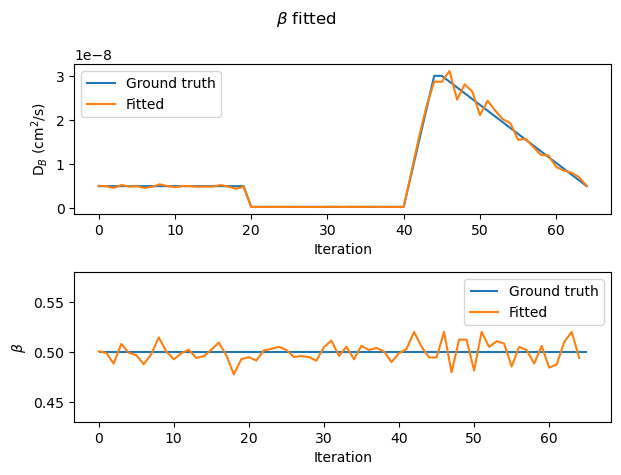

In [51]:
beta_calculator = fit_hom.BetaCalculator(mode="fit", beta_init=0.48, beta_bounds=(0.47, 0.52))
fitter = fit_hom.FitHomogeneous(
    tau,
    g2_norm_noisy,
    fitting_function,
    msd_model,
    beta_calculator,
    tau_lims_fit,
    g2_lim_fit,
    mua=mua,
    musp=musp,
    rho=rho,
    n=n,
    lambda0=lambda0,
)
fitted_data = fitter.fit()

plt.subplot(2, 1, 1)
plt.suptitle(r"$\beta$ fitted")
plt.plot(db, label="Ground truth")
plt.plot(fitted_data["db"], label="Fitted")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"D$_B$ (cm$^2$/s)")
plt.subplot(2, 1, 2)
plt.hlines(beta, 0, total_length, linestyle="-", color="tab:blue", label="Ground truth")
plt.plot(fitted_data["beta"], color="tab:orange", label="Fitted")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"$\beta$")
plt.ylim((0.43, 0.58))
plt.tight_layout()
plt.show()

### Modified Beer-Lambert law
Data analysis via the Modified Beer-Lambert law is also supported. The necessary functionalities are implemented in the
`inverse.mbl_homogeneous` module. Similarly to `inverse.fit_homogeneous`, it provides a `MBLHomogeneous` class to handle the
analysis of the measurement. It works almost the same as `FitHomogeneous`, with only a few differences.

Remember that the Modified Beer-Lambert law relates *changes* in autocorrelation to *changes* in `db` (or `v_ms`). That is to say,
to get absolute values of the parameters of interest, we first need to define a baseline from which changes occur. In order to do so,
we need `g2_norm_0`, the autocorrelation in baseline conditions, as well the baseline values of all the parameters: `mua0`, `musp0`,
and even `db0`.

Let's start from `g2_norm_0`, the baseline autocorrelation. We can simply obtain it by averaging `g2_norm` over the baseline iterations:

In [52]:
g2_norm_0 = np.mean(g2_norm[:, :baseline_length], axis=1)

In a real setting `mua0` and `musp0` would come from a TD NIRS measurement, and we could average them over the baseline as we did for `g2_norm_0`.
In our case we modeled constant optical properties, so `mua0 = mua` and `musp0 = musp`.

As for `db0`, we can get it from the fit we did earlier. Again, we average over the baseline:

In [53]:
db0 = np.mean(fitted_data["db"][:baseline_length])

Now we need a model for scatterer motion, and we can specify it as an instance of the `inverse.mbl_homogeneous.MSDModelMBL` class,
similarly to what we did earlier with `inverse.fit_homogeneous.MSDModelFit`. Along with the model, we need to specify the baseline value
of the parameter (`db0` in our case). Note that at the moment only the Brownian and ballistic models are supported.

Let's go ahead and create our Brownian `msd_model`:

In [54]:
import inverse.mbl_homogeneous as mbl

msd_model = mbl.MSDModelMBL(name="brownian", param0=db0)

Lastly, we need to specify the geometric model. Similarly to `FitHomogeneous`, we do so by passing the appropriate function to the
`MBLHomogeneous` class constructor. In this case, however, the function is not the fitting `g1_norm`, but rather a function
that returns the sensitivity coefficients for the geometry of interest, which can be found in the `forward` module
(see their documentation for details).

In our case, we are going to use `forward.homogeneous_semi_inf.d_factors`, which computes the sensitivity coefficients for the
homogeneous semi-infinite geometry:

In [55]:
d_factors_fn = hsi.d_factors

As was the case for `FitHomogeneous`, the arguments that this function takes besides `msd` must be passed as keyword arguments to the
`MBLHomogeneous` class constructor.

We are now ready to analyze the data using the Modified Beer-Lambert law. Let's create our `mbl_analyzer` with all the options we defined:

In [56]:
mbl_analyzer = mbl.MBLHomogeneous(
    tau,
    g2_norm_noisy,
    g2_norm_0,
    d_factors_fn,
    msd_model,
    mua,
    musp,
    mua0=mua,
    musp0=musp,
    rho=rho,
    n=n,
    lambda0=lambda0
)

We can call `mbl_analyzer.fit()` to perform the analysis. Note that plotting during the analysis is not supported, since there is
no fitting function to plot.

In [57]:
db_mbl = mbl_analyzer.fit()

C:\Users\marco\PycharmProjects\Fit-DCS\inverse\mbl_homogeneous.py:151: RuntimeWarning: divide by zero encountered in divide
  delta_od = -np.log((self.g2_norm - 1) / (g2_norm_0 - 1))
C:\Users\marco\PycharmProjects\Fit-DCS\inverse\mbl_homogeneous.py:151: RuntimeWarning: invalid value encountered in log
  delta_od = -np.log((self.g2_norm - 1) / (g2_norm_0 - 1))


We will typically get warnings saying that we tried to divide by 0, or that we tried to take the logarithm of a negative number. This
happens because of the noise, and is completely normal: `g2_norm` at later delay times has a low SNR and results in invalid values of `db`.

The `fit()` method returns a matrix the same size as `g2_norm`, containing the value of the parameter of interest (`db`, in our case)
for each iteration and lag time. We can plot the mean and standard deviation of `db_mbl` during the baseline to assess which lag
times to consider:

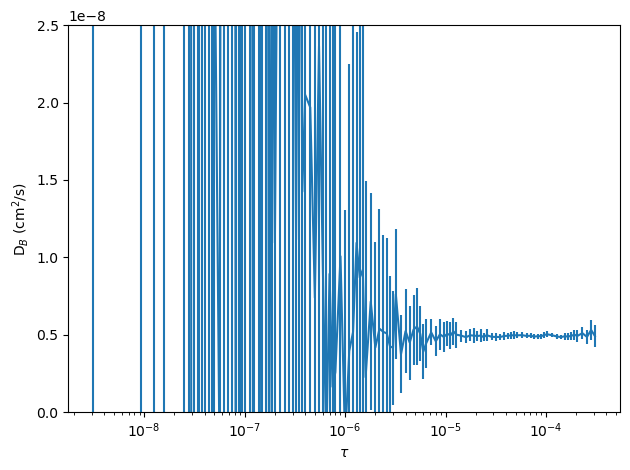

In [58]:
db_mbl_baseline_avg = np.mean(db_mbl[:, :baseline_length], axis=1)
db_mbl_baseline_sd = np.std(db_mbl[:, :baseline_length], axis=1)
plt.errorbar(tau, db_mbl_baseline_avg, db_mbl_baseline_sd)
plt.xscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel(r"D$_B$ (cm$^2$/s)")
plt.ylim((0, 5*baseline_value))
plt.tight_layout()
plt.show()

The signal is very noisy at small lag times, but for big values of `tau` the Modified Beer-Lambert law performs poorly
(notice the missing points). A good trade-off in this case could be `1e-5 s < tau < 3e-5 s`.

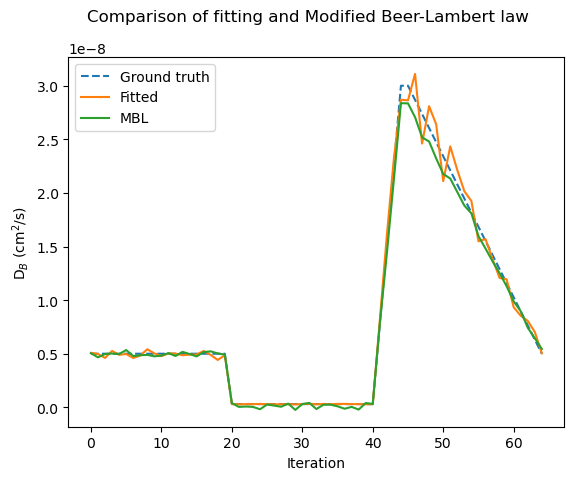

In [59]:
mask = np.logical_and(tau > 1e-5, tau < 3e-5)
db_mbl_signal = np.mean(db_mbl[mask, :], axis=0)
plt.plot(db, linestyle="--", label="Ground truth")
plt.plot(fitted_data["db"], label="Fitted")
plt.plot(db_mbl_signal, label="MBL")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"D$_B$ (cm$^2$/s)")
plt.suptitle("Comparison of fitting and Modified Beer-Lambert law")
plt.show()

Finally, we can see what happens if we select different intervals of `tau` over which to average the signal.

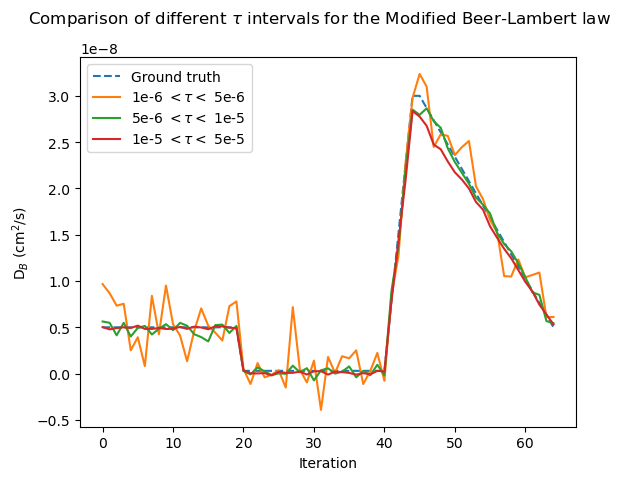

In [60]:
mask1 = np.logical_and(tau > 1e-6, tau < 5e-6)
db1 = np.mean(db_mbl[mask1, :], axis=0)
mask2 = np.logical_and(tau > 5e-6, tau < 1e-5)
db2 = np.mean(db_mbl[mask2, :], axis=0)
mask3 = np.logical_and(tau > 1e-5, tau < 5e-5)
db3 = np.mean(db_mbl[mask3, :], axis=0)

plt.plot(db, linestyle="--", label="Ground truth")
plt.plot(db1, label=r"1e-6 $< \tau <$ 5e-6")
plt.plot(db2, label=r"5e-6 $< \tau <$ 1e-5")
plt.plot(db3, label=r"1e-5 $< \tau <$ 5e-5")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"D$_B$ (cm$^2$/s)")
plt.suptitle(r"Comparison of different $\tau$ intervals for the Modified Beer-Lambert law")
plt.show()

As we can see, earlier delay times give noisier signals, while later delays result in cleaner signals, but tend to underestimate big changes.